In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt                                        # for plotting
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from utils.functions import load_dataset


train_set_x, _, train_set_y, test_set_x, _, test_set_y = load_dataset()

print(train_set_x.shape)
print(train_set_y.shape)
print(test_set_x.shape)
print(test_set_y.shape)

2023-08-08 22:55:08.684928: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 22:55:08.791777: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 22:55:10.264607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(209, 64, 64, 3)
(209,)
(50, 64, 64, 3)
(50,)


In [6]:
# normalize pixel values to be in interval [0, 1]
train_set_x_n = train_set_x / 255.0
test_set_x_n = test_set_x / 255.0

print("without normalization:")
print(train_set_x[0])
print("\nwith normalization:")
print(train_set_x_n[0])

without normalization:
[[[17 31 56]
  [22 33 59]
  [25 35 62]
  ...
  [ 1 28 57]
  [ 1 26 56]
  [ 1 22 51]]

 [[25 36 62]
  [28 38 64]
  [30 40 67]
  ...
  [ 1 27 56]
  [ 1 25 55]
  [ 2 21 51]]

 [[32 40 67]
  [34 42 69]
  [35 42 70]
  ...
  [ 1 25 55]
  [ 0 24 54]
  [ 1 21 51]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]

with normalization:
[[[0.06666667 0.12156863 0.21960784]
  [0.08627451 0.12941176 0.23137255]
  [0.09803922 0.1372549  0.24313725]
  ...
  [0.00392157 0.10980392 0.22352941]
  [0.00392157 0.10196078 0.21960784]
  [0.00392157 0.08627451 0.2       ]]

 [[0.09803922 0.14117647 0.24313725]
  [0.10980392 0.14901961 0.25098039]
  [0.11764706 0.15686275 0.2627451 ]
  ...
  [0.00392157 0.10588235 0.21960784]
  [0.00392157 0.09803922 0.21568627]
  [0.00784314

In [7]:
input_shape = (64, 64, 3)
num_classes = 1

model_cnn = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.3),     
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(num_classes, activation="sigmoid"),
    ]
)

2023-08-08 22:55:12.316703: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2023-08-08 22:55:12.383334: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2023-08-08 22:55:12.400568: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.


In [8]:
# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.92,
#     staircase=True)
opt = keras.optimizers.SGD(learning_rate=0.005)
# Compile the model.
model_cnn.compile(
  optimizer=opt,
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
print(model_cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dropout_1 (Dropout)         (None, 12544)             0         
          

In [9]:
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

# in order to achieve the accuracy of 82%, this was run 4 times, totalling 400 epochs.
# The only things that changed was the batch size, which was respectivelly: 64, 64, 128, 209
results = model_cnn.fit(
  train_set_x_n,
  train_set_y,
  epochs=100,
  batch_size=209,
  validation_data=(test_set_x_n, test_set_y),
  verbose = 1,
  # callbacks=[early_stop]
)


Epoch 1/100


2023-08-08 22:55:13.123015: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2023-08-08 22:55:13.754399: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.


1/1 [==============================] - 3s 3s/step - loss: 0.6641 - accuracy: 0.6364 - val_loss: 0.7083 - val_accuracy: 0.3400
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.6544 - accuracy: 0.6459 - val_loss: 0.7225 - val_accuracy: 0.3400
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.6504 - accuracy: 0.6555 - val_loss: 0.7328 - val_accuracy: 0.3400
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.6494 - accuracy: 0.6507 - val_loss: 0.7420 - val_accuracy: 0.3400
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.6455 - accuracy: 0.6555 - val_loss: 0.7482 - val_accuracy: 0.3400
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.6496 - accuracy: 0.6555 - val_loss: 0.7536 - val_accuracy: 0.3400
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.6428 - accuracy: 0.6555 - val_loss: 0.7564 - val_accuracy: 0.3400
Epoch 8/100
1/1 [=============================

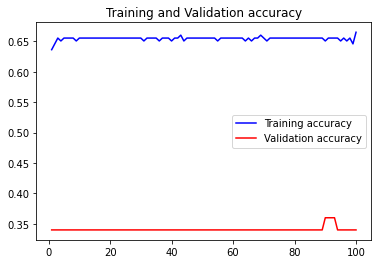

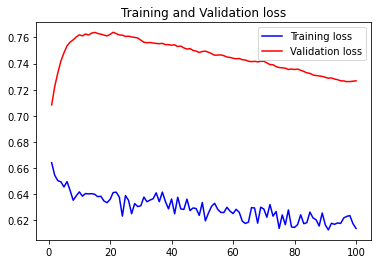

2/2 [==============================] - 0s 43ms/step
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]

 [[0.0000000e+00]
 [0.0000000e+00]
 [4.9243512e-30]
 [2.0445795e-20]
 [5.1463978e-17]]

 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


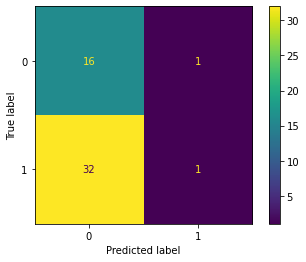

In [10]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label= 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label= 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label= 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

num_classes = 2
# one-hot-encoding y set
y_test_multi_class = keras.utils.to_categorical(test_set_y, num_classes)
y_test_prediction = model_cnn.predict(test_set_x)
y_test_prediction_rounded = [round(x) for arr in y_test_prediction for x in arr]
y_test_prediction_multi_class = keras.utils.to_categorical(y_test_prediction_rounded, num_classes)


# tf.compat.v1.disable_eager_execution() # this (in theory) avoids a warning message, more info in https://stackoverflow.com/questions/69136518/tensorflow-2-getting-warningtensorflowx-out-of-the-last-x-calls-to-function
print(y_test_multi_class[3:8])
print("\n",y_test_prediction[3:8])
print("\n",y_test_prediction_multi_class[3:8])

#Your input to confusion_matrix must be an array of int not one hot encodings.
ConfusionMatrixDisplay.from_predictions(y_test_multi_class.argmax(axis=1), y_test_prediction_multi_class.argmax(axis=1))

# Pickling the model for deployment

In [13]:
import pickle

pickle.dump(model_cnn, open('model_cnn2.pkl', 'wb'))

## Printing the version of TensorFlow and Keras so we can create a correspondent requirements.txt file

In [16]:
!python3 -c "import tensorflow as tf; print(tf.__version__)"

2023-08-08 23:03:13.593260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2.13.0


In [17]:
!python3 -c "import keras; print(keras.__version__)"

2023-08-08 23:03:20.271260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2.13.1
